## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [4]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

### Load strm functions

In [8]:
strm_ds = xr.open_dataset('strm_functions.nc')

### Make Aaron's AHT data

In [6]:
one_file = scipy.io.loadmat('../aaron_aht_stuff/monthly_AHT/1980_1_AHT.mat')
aaron_lat = one_file['lat'].flatten()

dataDir = "../aaron_aht_stuff/monthly_AHT/"

all_ahts = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_ahts_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_tes = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_tes_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_ses = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_dry = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_moist = np.zeros((len(times), len(aaron_lat.flatten())))
all_ses_pot = np.zeros((len(times), len(aaron_lat.flatten())))

all_mmcs = np.zeros((len(times), len(aaron_lat.flatten())))

for file in sorted(os.listdir(dataDir)) :
    
    year = file[:4]
    month = re.sub(r'[^0-9]', '', file[5:7])
    
    time_idx = (int(year) - 1980) * 12 + (int(month) -1)
    
    data = scipy.io.loadmat(dataDir+file)
    
    this_aht = data['AHT'].flatten()
    this_aht_dry = data['AHT_dry'].flatten()
    this_aht_moist = data['AHT_moist'].flatten()
    this_aht_pot = data['AHT_pot'].flatten()
    
    this_te = data['TE'].flatten()
    this_te_dry = data['TE_dry'].flatten()
    this_te_moist = data['TE_moist'].flatten()
    this_te_pot = data['TE_pot'].flatten()
    
    this_se = data['SE'].flatten()
    this_se_dry = data['SE_dry'].flatten()
    this_se_moist = data['SE_moist'].flatten()
    this_se_pot = data['SE_pot'].flatten()
    
    this_mmc = data['MME'].flatten()
    
    all_ahts[time_idx,:] = this_aht
    all_ahts_dry[time_idx,:] = this_aht_dry
    all_ahts_moist[time_idx,:] = this_aht_moist
    all_ahts_pot[time_idx,:] = this_aht_pot
    
    all_tes[time_idx,:] = this_te
    all_tes_dry[time_idx,:] = this_te_dry
    all_tes_moist[time_idx,:] = this_te_moist
    all_tes_pot[time_idx,:] = this_te_pot
    
    all_ses[time_idx,:] = this_se
    all_ses_dry[time_idx,:] = this_se_dry
    all_ses_moist[time_idx,:] = this_se_moist
    all_ses_pot[time_idx,:] = this_se_pot
    
    all_mmcs[time_idx,:] = this_mmc

all_mmcs_dry = all_ahts_dry - all_tes_dry - all_ses_dry
all_mmcs_moist = all_ahts_moist - all_tes_moist - all_ses_moist
all_mmcs_pot = all_ahts_pot - all_tes_pot - all_ses_pot

In [7]:

final_ds = xr.Dataset(
                        data_vars = dict(
                            total_aht=(['time', 'latitude'], all_ahts),
                            total_aht_dry=(['time', 'latitude'], all_ahts_dry),
                            total_aht_moist=(['time', 'latitude'], all_ahts_moist),
                            total_aht_pot=(['time', 'latitude'], all_ahts_pot),
                            total_aht_dry_pot=(['time', 'latitude'], all_ahts_dry + all_ahts_pot),
                            te_aht=(['time', 'latitude'], all_tes),
                            te_aht_dry=(['time', 'latitude'], all_tes_dry),
                            te_aht_moist=(['time', 'latitude'], all_tes_moist),
                            te_aht_pot=(['time', 'latitude'], all_tes_pot),
                            te_aht_dry_pot=(['time', 'latitude'], all_tes_dry + all_tes_pot),
                            se_aht=(['time', 'latitude'], all_ses),
                            se_aht_dry=(['time', 'latitude'], all_ses_dry),
                            se_aht_moist=(['time', 'latitude'], all_ses_moist),
                            se_aht_pot=(['time', 'latitude'], all_ses_pot),
                            se_aht_dry_pot=(['time', 'latitude'], all_ses_dry + all_ses_pot),
                            mmc_aht=(['time', 'latitude'], all_mmcs),
                            mmc_aht_dry=(['time', 'latitude'], all_mmcs_dry),
                            mmc_aht_moist=(['time', 'latitude'], all_mmcs_moist),
                            mmc_aht_pot=(['time', 'latitude'], all_mmcs_pot),
                            mmc_aht_dry_pot=(['time', 'latitude'], all_mmcs_dry + all_mmcs_pot),
                        ),
                        coords=dict(
                            time = times,
                            latitude=aaron_lat)
    )
    
#final_ds.to_netcdf('aaron_aht_data_through_2018_with_time.nc', mode='w')

### Plot climatological stream function

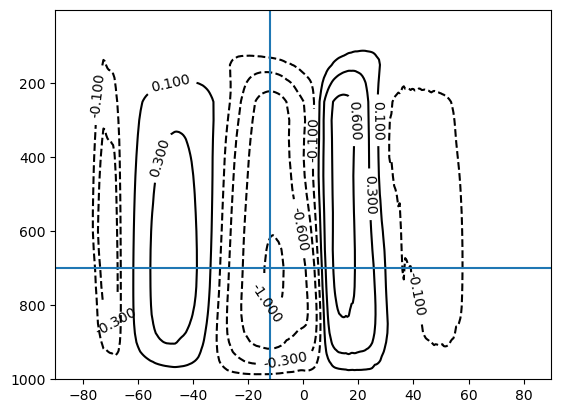

In [63]:
clima_strm = strm_ds.strm_fnct.mean(['time'])

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')
plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

plt.axhline(700)
plt.axvline(-12)

#plt.xlim([-50, 50])
plt.show()

### Now let's see changes

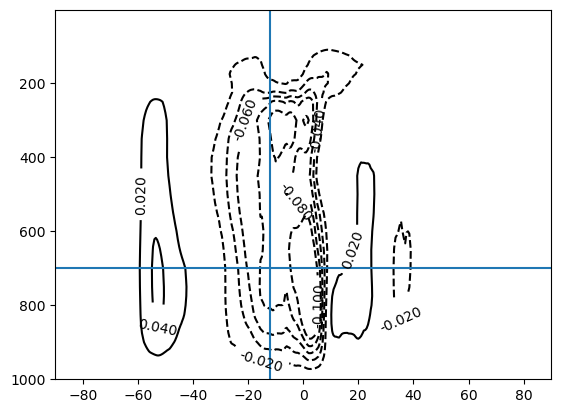

In [66]:
strm_start = strm_ds.strm_fnct.sel(time=slice('1980', '1989')).mean(['time'])
strm_end = strm_ds.strm_fnct.sel(time=slice('2009', '2018')).mean(['time'])
                                   
which_levels = [-.1, -.08, -0.06, -0.04, -0.02, .02, .04, .06, .08, .1]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, (strm_end - strm_start)/1e11, levels=which_levels, colors='k')
plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

plt.axhline(700)
plt.axvline(-12)

#plt.xlim([-50, 50])
plt.show()

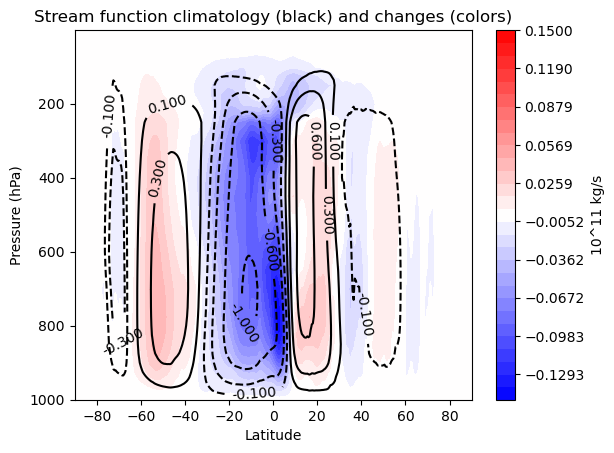

In [72]:
clima_strm = strm_ds.strm_fnct.mean(['time'])

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')

strm_start = strm_ds.strm_fnct.sel(time=slice('1980', '1989')).mean(['time'])
strm_end = strm_ds.strm_fnct.sel(time=slice('2009', '2018')).mean(['time'])

contf = plt.contourf(lats, levels, (strm_end - strm_start)/1e11, levels=np.linspace(-.15, .15, 30), cmap='bwr')

plt.colorbar(contf, label='10^11 kg/s')

plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

#plt.axhline(700)
#plt.axvline(-12)

#plt.xlim([-50, 50])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.title('Stream function climatology (black) and changes (colors)')

#plt.savefig('../figures/aht_changes/stream_function_clima_and_changes')

plt.show()

### Let's see trends by month in various places

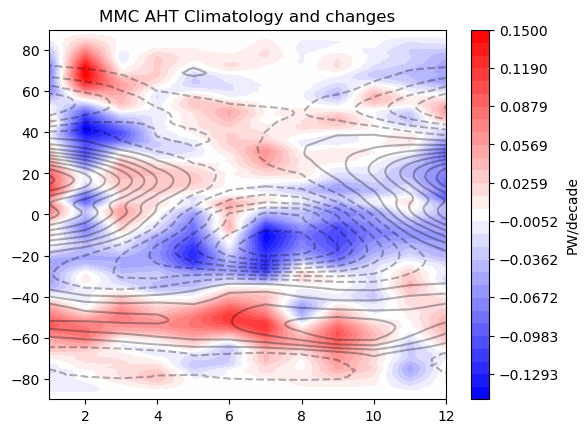

In [54]:
month_grouped_aht = final_ds.groupby('time.month')

monthly_trends_aht = np.zeros((12, len(lats)))

for i in range(12):
    
    data_new_time_dim = month_grouped_aht[i+1].assign_coords({"time": range(39)})
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends_aht[i,:] = this_trend.mmc_aht_polyfit_coefficients.sel(degree=1)

plt.contour(range(1,13), lats, month_grouped_aht.mean(['time']).mmc_aht.T/1e15,
            levels=np.linspace(-6, 6, 30), colors='k', alpha=0.3)

perc_change = 100 * monthly_trends_aht  / month_grouped_aht.mean(['time']).mmc_aht

masked_perc = np.ma.masked_array(10*perc_change.T, mask=(abs(month_grouped_aht.mean(['time']).mmc_aht.T/1e15)<=.3))

#plt.contourf(range(1, 13), lats, masked_perc, levels=np.linspace(-20, 20, 80), cmap='bwr')
#plt.pcolormesh(range(1, 13), lats, masked_perc, cmap='bwr', vmin=-20, vmax=20)

plt.contourf(range(1, 13), lats, 10*monthly_trends_aht.T/1e15, levels=np.linspace(-.15, .15, 30), cmap='bwr')

plt.colorbar(label='PW/decade')

plt.title('MMC AHT Climatology and changes')

#plt.savefig('../figures/hadley_cell_change_figs/mmc_aht_clima_and_changes')
plt.show()

In [12]:
strm_ds

<xarray.Dataset>
Dimensions:    (time: 516, level: 37, latitude: 361)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2021-12-31
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * level      (level) int64 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
Data variables:
    strm_fnct  (time, level, latitude) float64 ...

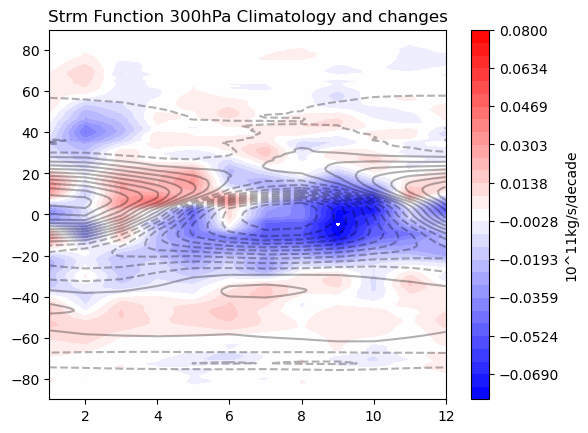

In [60]:
month_grouped_strm = strm_ds.sel(level=300).groupby('time.month')

monthly_trends_strm = np.zeros((12, len(lats)))

for i in range(12):
    
    data_new_time_dim = month_grouped_strm[i+1].assign_coords({"time": range(43)})
    this_trend = data_new_time_dim.polyfit(dim='time', deg=1)
    monthly_trends_strm[i,:] = this_trend.strm_fnct_polyfit_coefficients.sel(degree=1)

plt.contour(range(1,13), lats, month_grouped_strm.mean(['time']).strm_fnct.T/1e11,
            levels=np.linspace(-3, 3, 30), colors='k', alpha=0.3)

perc_change = 100 * monthly_trends_strm  / month_grouped_strm.mean(['time']).strm_fnct
#plt.contourf(range(1, 13), lats, 10*perc_change.T, levels=np.linspace(-20, 20, 30), cmap='bwr')

plt.contourf(range(1, 13), lats, 10*monthly_trends_strm.T/1e11, levels=np.linspace(-.08, .08, 30), cmap='bwr')

plt.colorbar(label='10^11kg/s/decade')

plt.title('Strm Function 300hPa Climatology and changes')

#plt.savefig('../figures/hadley_cell_change_figs/strm_fnct_300hPa_clima_and_changes')
plt.show()

### Hadley cell stuff

In [11]:
hadley_strength = pd.read_csv('../hadley_cell_strength_values.csv')

In [338]:
hadley_strength

,year,psi^min,psi^min(800 hPa),psi^min(775 hPa),psi^min(750 hPa),psi^min(700 hPa),psi^min(650 hPa),psi^min(600 hPa),psi^min(550 hPa),psi^min(500 hPa),psi^min(450 hPa),psi^min(400 hPa),<psi^min>_p,"psi(phi^min, p^min)",psi_SHC
0,1979,-1.15015,-1.10624,-1.13564,-1.15015,-1.13689,-1.07961,-1.00631,-0.93804,-0.87880,-0.83063,-0.79794,-0.88667,-1.10157,-0.44486
1,1980,-1.13232,-1.09872,-1.12426,-1.13232,-1.10778,-1.05201,-0.98822,-0.93426,-0.88807,-0.84635,-0.80544,-0.88169,-1.10778,-0.46017
2,1981,-1.10726,-1.08102,-1.10161,-1.10726,-1.08871,-1.04580,-0.99456,-0.94029,-0.88502,-0.84102,-0.81037,-0.88029,-1.08599,-0.44198
3,1982,-1.13745,-1.09575,-1.12503,-1.13745,-1.11731,-1.05953,-0.99279,-0.93480,-0.88227,-0.83890,-0.80258,-0.88572,-1.11640,-0.45738
4,1983,-1.13617,-1.11013,-1.12988,-1.13617,-1.12070,-1.07820,-1.02507,-0.97439,-0.92675,-0.88561,-0.84684,-0.90973,-1.10165,-0.42741
5,1984,-1.01495,-0.98023,-1.00192,-1.01495,-1.01154,-0.97777,-0.93187,-0.88861,-0.84768,-0.81138,-0.77837,-0.81917,-0.99146,-0.39560
6,1985,-1.03448,-0.98931,-1.01659,-1.03398,-1.03448,-0.99659,-0.94674,-0.89555,-0.84847,-0.80896,-0.77746,-0.82822,-1.02445,-0.41610
7,1986,-1.09537,-1.04888,-1.07983,-1.09537,-1.08756,-1.04488,-0.99169,-0.93803,-0.88948,-0.85002,-0.81974,-0.87421,-1.08756,-0.43728
8,1987,-1.17945,-1.11411,-1.15201,-1.17528,-1.17945,-1.13713,-1.07980,-1.01908,-0.96390,-0.92013,-0.88485,-0.93806,-1.17291,-0.45509
9,1988,-1.07558,-1.03249,-1.05700,-1.07037,-1.07558,-1.04904,-1.00672,-0.96279,-0.92260,-0.89009,-0.86119,-0.88456,-1.05828,-0.44043


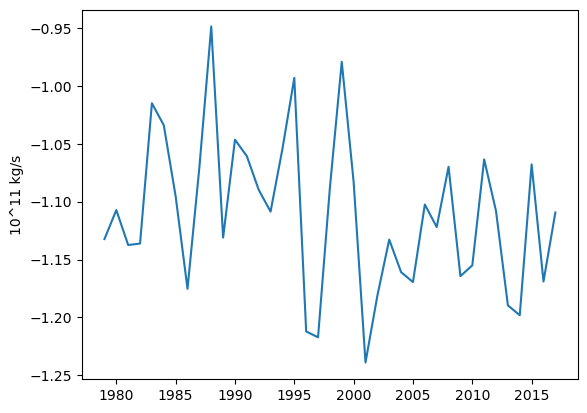

In [364]:
years=range(1979, 2018)

#plt.plot(years, hadley_strength['psi_SHC'][1:])
plt.plot(years, hadley_strength['psi^min(750 hPa)'][1:])

plt.ylabel('10^11 kg/s')
#plt.savefig('../figures/5_24_22_meeting/hadley_cell_sh_mass_transport_time_series')

plt.show()